In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import os
import os.path
from csv import reader
from networkx.algorithms import approximation
import matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import hypergeom

In [4]:
def make_disease_gene_dictionary(interactome_dg_file):
	Gi = open(interactome_dg_file, "r")
	ppi_dg_dict = {}
	for line in Gi:
		stripped_line = line.strip()
		line_list = stripped_line.split()
		disease_id = line_list[0]
		gene_id = line_list[-1]
		
		if disease_id in ppi_dg_dict:
			updated_list = ppi_dg_dict[disease_id]
			updated_list.append(gene_id)  
			ppi_dg_dict[disease_id] = updated_list
		else:
			ppi_dg_dict[disease_id] = [gene_id]
	Gi.close()
	ppi_dg_dict.pop('#');
	return(ppi_dg_dict)

def convert_to_integers(unconverted,interactome_mcl_dir):
	converted = []
	G_initial = '../summer-2022/'+interactome_mcl_dir+'orca5/g_network_nodeid.txt'
	Gi = open(G_initial, "r")
	for line in Gi:
		stripped_line = line.strip()
		pair_list = stripped_line.split()

		if pair_list[1] in unconverted:
			converted.append(pair_list[0])
	Gi.close()
	return(converted)

def get_all_clusters(interactome_mcl_dir):
	all_clusters = []
	cluster_lengths = []
	
	for i in range(30):

		G_initial = interactome_mcl_dir + 'inflation_tests/G'+str(i)+'_I3.0'
		ith_clusters = []
		ith_lengths = []
	
		Gi = open(G_initial, "r")
		for line in Gi:
			
			stripped_line = line.strip()
			line_list = stripped_line.split()
			
			ith_clusters.append(line_list)
			ith_lengths.append(len(line_list))

		Gi.close()

		#add all the nodes taken off by the graphlet step
		all_clusters.append(ith_clusters)
		cluster_lengths.append(ith_lengths)
	return(all_clusters,cluster_lengths)

# Given all of the clusters and the target nodes, it will return a list of lists of the number of target nodes
# in each cluster
def get_target_counts(all_clusters,target_nodes):

	all_target_counts = []


	for i in range(len(all_clusters)):

		ith_target_counts = []
	

		for j in range(len(all_clusters[i])):

			count = 0
			for target in target_nodes:
				if target in all_clusters[i][j]:
					count += 1
					
			
			#if count>0:
			ith_target_counts.append(count)

		
		if len(ith_target_counts)<0:
			ith_target_counts = [None]
	

		all_target_counts.append(ith_target_counts)

	return(all_target_counts)

def list_of_strings(list,prefix='',suffix=''):
    return_list = []
    for item in list:
        return_list.append(prefix+str(item)+suffix)
    return return_list

# a max function that also returns the index of the max value in the list
def max_returns_index(ranlis):
    mx = 0
    mx_index = 0
    for i in range(len(ranlis)):
        if ranlis[i] > mx:
            mx = ranlis[i]
            mx_index = i
    return(mx,mx_index)

def convert_from_integers(integers,interactome_mcl_dir):
	original = []
	G_initial = '../summer-2022/'+interactome_mcl_dir+'orca5/g_network_nodeid.txt'
	Gi = open(G_initial, "r")
	for line in Gi:
		stripped_line = line.strip()
		pair_list = stripped_line.split()

		if pair_list[0] in integers:
			original.append(pair_list[1])
	Gi.close()
	return(original)


In [5]:
interactome_dg_file = '../summer-2022/data/disease_associations/ppi_DG.tsv'
interactome_mcl_dir = 'ppi_out/'
disease_gene_dict = make_disease_gene_dictionary(interactome_dg_file)
all_clusters,cluster_lengths = get_all_clusters(interactome_mcl_dir)

ids_lis = []
for ids in disease_gene_dict:
    ids_lis.append(ids)

In [6]:
all_counts = []

for disease_id in disease_gene_dict:
    target_nodes_unconverted = disease_gene_dict[disease_id]
    target_nodes = convert_to_integers(target_nodes_unconverted,interactome_mcl_dir)
    target_counts = get_target_counts(all_clusters,target_nodes)
    all_counts.append(target_counts)

In [7]:
P = np.zeros(len(disease_gene_dict)*30).reshape(30,len(disease_gene_dict))
significant_array = np.zeros(len(disease_gene_dict)*30).reshape(30,len(disease_gene_dict))
cluster_index_array = np.zeros(len(disease_gene_dict)*30).reshape(30,len(disease_gene_dict))
significant_labels = []
sig_counts = []

for j in range(519):
    disease_counts_by_graphlet = []
    target_counts = all_counts[j]
    for i in range(30):
        if len(target_counts[i]) > 0:
                mx, mx_index = max_returns_index(target_counts[i])
                cluster_index_array[i][j] = mx_index
                P[i][j] = max(target_counts[i])
                
                disease_counts_by_graphlet.append(max(target_counts[i]))
    if max(disease_counts_by_graphlet) > 4:
        sig_counts.append(target_counts)
        significant_labels.append(list(disease_gene_dict)[j])
        for i in range(30):
            if len(target_counts[i]) > 0:
                significant_array[i][j] = max(target_counts[i])

In [8]:
step1 = significant_array.transpose()
step2 = step1[~np.all(step1 == 0, axis=1)]
significant_array = step2.transpose()

In [50]:
# Just all of the target counts (P)
row_names = list_of_strings(list(range(30)),'G')
row_names.append('DG_size')

dg_list_sizes = []
for ids in disease_gene_dict:
    dg_list_sizes.append(len(disease_gene_dict[ids]))
    
P = np.vstack([P,dg_list_sizes])
    
column_names = ids_lis

#pd.DataFrame(np.array(P),columns=column_names,index = row_names).to_csv('ppi_dg_maxs4.csv')

In [116]:
# Special target counts

x_sizes = []
for label in significant_labels:
    x_sizes.append(len(disease_gene_dict[label]))

row_names = list_of_strings(list(range(30)),'G')
row_names.append('DG_size')

column_names = significant_labels

significant_array = np.vstack([significant_array,x_sizes])

pd.DataFrame(significant_array,columns=column_names,index = row_names).to_csv('ppi_dg_special_test1.csv')


In [176]:
# Special target counts with Cluster lengths
column_len = len(significant_labels)
X_with_cluster_lengths = np.zeros(2*column_len*30).reshape(30,2*column_len)
count = 0
for j in range(519):
    if significant_array[0][j] != 0:
        for i in range(30):
            X_with_cluster_lengths[i][count] = significant_array[i][j]
            cor_cluster = int(cluster_index_array[i][j]) #corresponding cluster
            X_with_cluster_lengths[i][count+1] = len(all_clusters[i][cor_cluster])
        count+=2

x_sizes = []
for label in significant_labels:
    x_sizes.append(len(disease_gene_dict[label]))
    x_sizes.append(0)

row_names = list_of_strings(list(range(30)),'G')
row_names.append('DG_size')

column_names = []
for label in significant_labels:
    column_names.append(label)
    column_names.append('')


X_with_cluster_lengths = np.vstack([X_with_cluster_lengths,x_sizes])

pd.DataFrame(np.array(X_with_cluster_lengths),columns=column_names,index = row_names).to_csv('ppi_dg_special_clusterlen2.csv')

In [131]:
len(all_counts)

519

In [162]:
len(list(disease_gene_dict))

519

In [148]:
total_dg_by_graphlet = np.zeros(518*30).reshape(30,518)
total_genes_by_graphlet = []

for i in range(30):
    count = 0 
    for cluster in all_clusters[i]:
        for node in cluster:
            count += 1
    total_genes_by_graphlet.append(count)

    for j in range(518):
        total_dg_by_graphlet[i][j] = sum(all_counts[j][i])

In [159]:
i=29
j=7 

num_of_poss_dg = total_dg_by_graphlet[i][j]

total_genes = total_genes_by_graphlet[i]

cor_cluster = int(cluster_index_array[i][j]) #corresponding cluster
chosen_cluster_size = len(all_clusters[i][cor_cluster])

correct_dg = P[i][j]

print(correct_dg, total_genes, num_of_poss_dg, chosen_cluster_size)

hypergeom.sf(correct_dg-1, total_genes, num_of_poss_dg, chosen_cluster_size)

21.0 7642 22.0 87


2.4624152605447643e-41

In [9]:
# Attempting the hypergeometric test
H = np.zeros(519*30).reshape(30,519)

dg_list_sizes = []
for ids in disease_gene_dict:
    dg_list_sizes.append(len(disease_gene_dict[ids]))

for j in range(519):
    for i in range(30):

        num_of_poss_dg = dg_list_sizes[j]
        #total_dg_by_graphlet[i][j]
        
        total_genes = 21538
        #total_genes_by_graphlet[i]

        cor_cluster = int(cluster_index_array[i][j]) #corresponding cluster
        chosen_cluster_size = len(all_clusters[i][cor_cluster])

        correct_dg = P[i][j]

        H[i][j] = hypergeom.sf(correct_dg-1, total_genes, num_of_poss_dg, chosen_cluster_size)

row_names = list_of_strings(list(range(30)),'G')
row_names.append('DG_size')


    
#H = np.vstack([H,dg_list_sizes])
    
column_names = ids_lis

#pd.DataFrame(H,columns=column_names,index = row_names).to_csv('ppi_dg_hypergeo3.csv')

In [163]:
#pd.DataFrame(H)

In [10]:
H[0]

array([3.71616429e-01, 1.10649366e-01, 3.26977187e-08, 9.79011832e-07,
       3.17019494e-02, 3.13075002e-02, 6.43392276e-02, 2.97915733e-45,
       1.12630962e-01, 1.67061082e-03, 3.47470625e-04, 7.08264829e-03,
       1.51337492e-06, 1.23849048e-04, 3.24599770e-03, 1.64527572e-02,
       7.63602394e-03, 4.24326291e-05, 6.77986055e-06, 2.73898709e-01,
       3.04332727e-03, 3.83241362e-05, 2.95323500e-01, 4.58799840e-03,
       1.72758983e-02, 1.18757470e-05, 1.06703667e-04, 3.92161785e-05,
       9.82798358e-05, 2.42632545e-04, 2.02408231e-02, 1.02255025e-01,
       3.53551975e-06, 8.14320248e-03, 3.92356460e-07, 5.18913769e-03,
       4.17187565e-03, 1.67292626e-02, 1.48514404e-02, 2.28332265e-05,
       2.43191845e-01, 1.35761042e-06, 1.06427701e-01, 1.00755147e-01,
       4.86560693e-03, 2.03373832e-01, 5.92851631e-03, 6.59608485e-01,
       2.93765831e-05, 4.91233728e-02, 9.55566238e-05, 1.03162886e-03,
       1.00137534e-01, 1.38438033e-02, 9.70955994e-03, 1.03992411e-02,
      

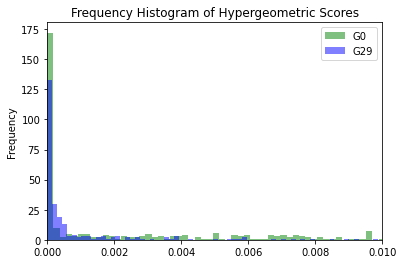

In [34]:
x1 = H[0]
x2 = H[29]
#x3 = H[8]
#x4 = H[27]

kwargs = dict(alpha=0.5, bins=4000)


plt.hist(x1, **kwargs, color='g', label='G0')
plt.hist(x2, **kwargs, color='b', label='G29')
#plt.hist(x3, **kwargs, color='r', label='G8')
#plt.hist(x4, **kwargs, color='k', label='G27')
plt.gca().set(title='Frequency Histogram of Hypergeometric Scores', ylabel='Frequency')
plt.xlim(0,.01)
plt.legend();

### Venn Diagrams

In [261]:
disease = 0
for i in range(519):
    if ids_lis[i] == 'C0018843':
        disease = i

In [263]:
zero_index = int(cluster_index_array[0][disease])
zero_cluster = all_clusters[0][zero_index]
tn_index = int(cluster_index_array[29][disease])
tn_cluster = all_clusters[29][tn_index]
tf_index = int(cluster_index_array[24][disease])
tf_cluster = all_clusters[24][tf_index]
print(len(zero_cluster),len(tn_cluster),len(tf_cluster))

9 18 3


In [262]:
fot_dg = convert_to_integers(disease_gene_dict['C0018843'],interactome_mcl_dir)


In [266]:
len(fot_dg)

12

In [264]:
list(set(tn_cluster) & set(fot_dg))

['8', '1196', '2004', '6168', '6533']

In [265]:
list(set(zero_cluster) & set(fot_dg))

['2004']

In [ ]:
print

In [257]:
# Converting to original labels
original_dg = disease_gene_dict['C0023473']

zero_original = convert_from_integers(zero_cluster,interactome_mcl_dir)

tn_original = convert_from_integers(tn_cluster,interactome_mcl_dir)

In [258]:
list(set(zero_original) & set(original_dg))

['1432']

In [259]:
list(set(tn_original) & set(original_dg))

['8864', '1407', '1408', '5187', '8863']

In [260]:
print(original_dg)

print(zero_original)

print(tn_original)

['1407', '1408', '1432', '23532', '240', '25', '26040', '2950', '3161', '3309', '332', '3440', '406', '5187', '5657', '613', '7015', '7490', '768', '861', '8863', '8864']
['1432', '5600', '1852', '7867', '7365', '6300', '56940', '5616', '91807', '1844', '79740']
['1408', '27373', '8914', '8864', '1407', '50514', '5187', '8863']
